In [1]:
# Standard library imports
import os
import json
from warnings import simplefilter

# Third-party imports
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import bernoulli, gaussian_kde
from scipy.special import expit as sigmoid
from sklearn.datasets import make_classification, make_moons
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    KFold,
    cross_val_score,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, RationalQuadratic
from sklearn.metrics import pairwise_distances, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from matplotlib.colors import Normalize

# Domain-specific imports
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AtomPairs import Pairs

# Ignore future warnings for cleaner output
simplefilter(action="ignore", category=FutureWarning)

# Matplotlib settings
plt.rcParams["text.usetex"] = True
plt.rcParams.update({"font.family": "serif", "font.serif": ["Times New Roman"]})

# Load Preprocessed Data

In [26]:
testing1_size_performance = pd.read_csv("testing1_size_vs_performance.csv")

testing2_size_performance = pd.read_csv("testing2_size_vs_performance.csv")

In [30]:
print(testing1_size_performance)

    s_R2_score_mean  s_R2_score_std  NGED_R2_score_mean  NGED_R2_score_std  \
0          0.895072        0.003786            0.942065           0.001378   
1          0.892014        0.006034            0.940190           0.003245   
2          0.886713        0.003903            0.937228           0.001997   
3          0.882081        0.003443            0.934416           0.002120   
4          0.873113        0.005795            0.928170           0.002734   
5          0.860876        0.009377            0.918824           0.007071   
6          0.843931        0.010048            0.904669           0.005035   
7          0.639768        0.101958            0.695710           0.105753   
8          0.560490        0.133064            0.607364           0.133269   
9          0.188804        0.365809            0.244228           0.377805   
10         0.035495        0.308356            0.124194           0.247472   
11        -0.130770        0.108056           -0.035874         

In [31]:
print(testing2_size_performance)

    s_R2_score_mean  s_R2_score_std  NGED_R2_score_mean  NGED_R2_score_std  \
0          0.874734        0.001055            0.925506           0.000481   
1          0.872073        0.005935            0.924888           0.003622   
2          0.870337        0.003603            0.923972           0.002688   
3          0.866122        0.003494            0.921737           0.002442   
4          0.862143        0.003960            0.918460           0.002335   
5          0.850145        0.009970            0.909494           0.007363   
6          0.829258        0.011301            0.893719           0.004500   
7          0.620923        0.107561            0.670522           0.114745   
8          0.542917        0.137491            0.583143           0.142292   
9          0.166605        0.351915            0.205887           0.380600   
10        -0.048960        0.370129            0.045749           0.269817   
11        -0.186509        0.172742           -0.082302         

# Plot Performance vs Size

## $R^2$ and MAE for s

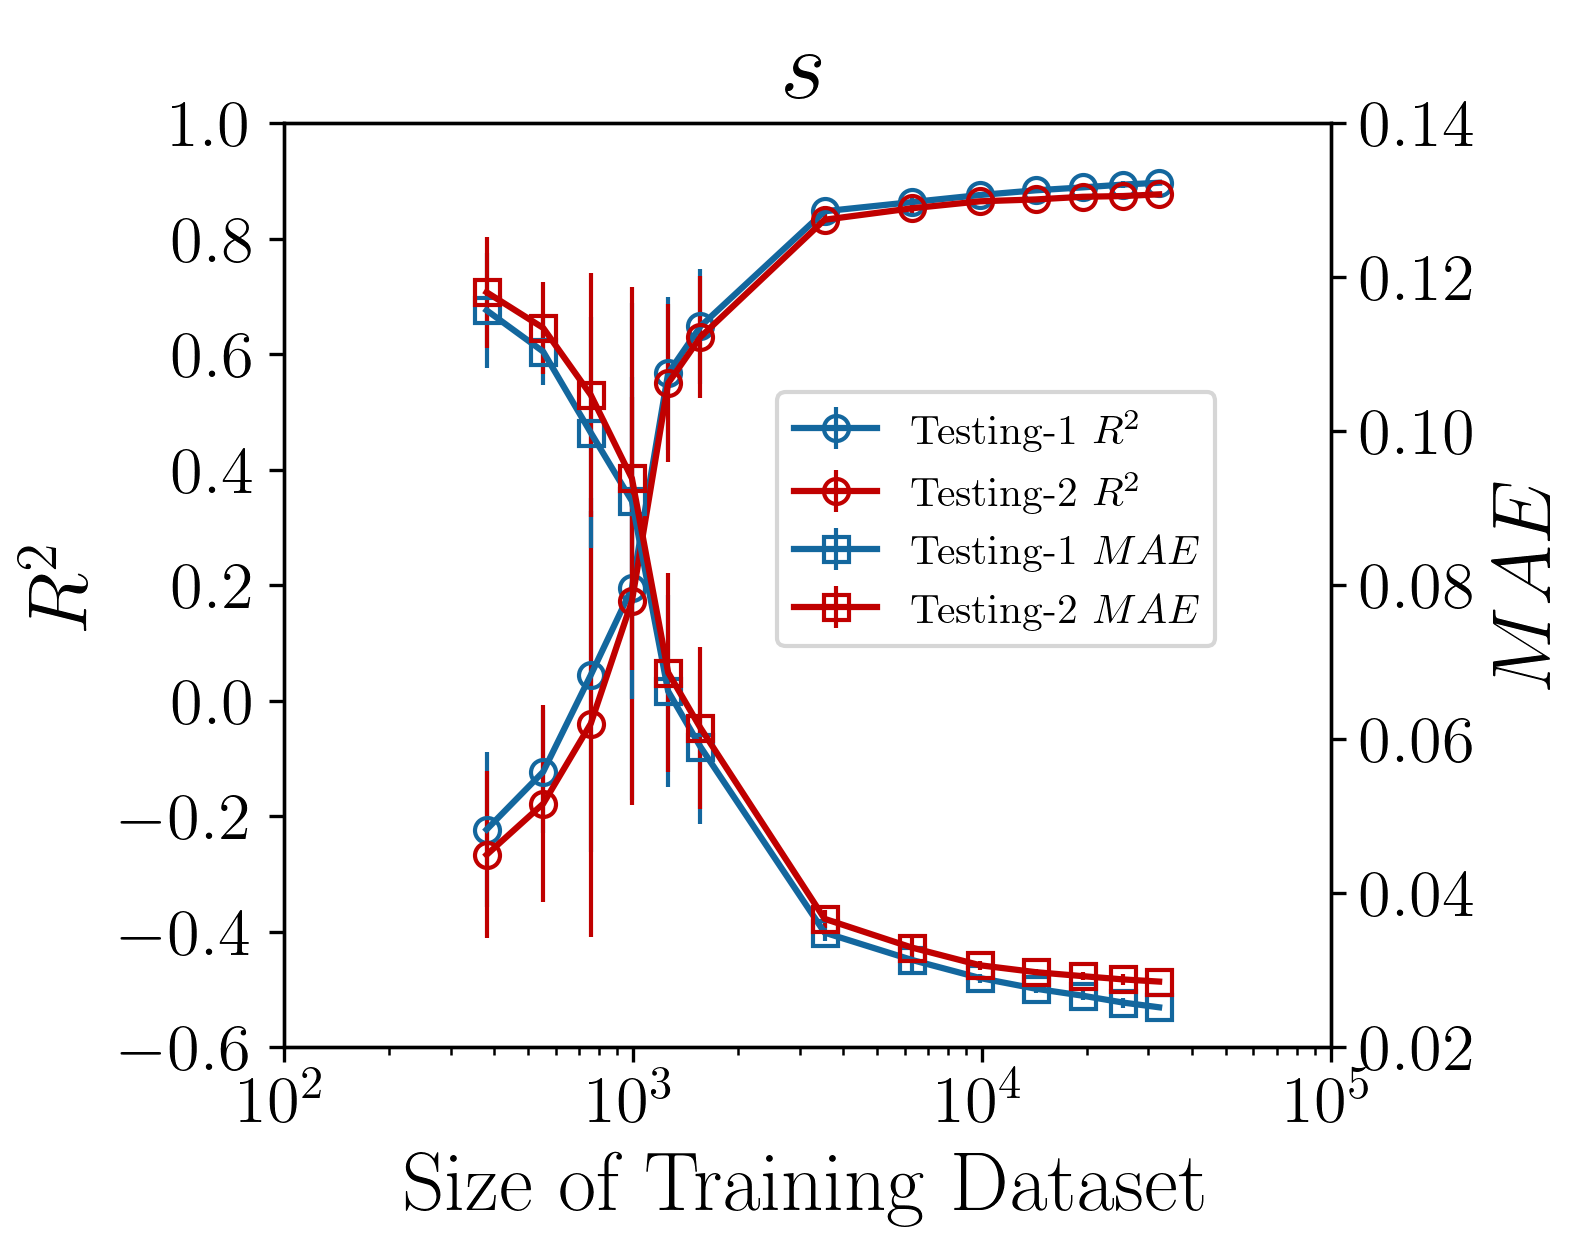

In [44]:
fig, ax1 = plt.subplots(figsize=(4.5, 4), dpi=300)
ax1.errorbar(
    testing1_size_performance["size"]
    * 200
    * (testing1_size_performance["size"] * 200 - 1),
    testing1_size_performance["s_R2_score_sym_mean"],
    testing1_size_performance["s_R2_score_sym_std"],
    marker="o",
    color="#13679E",
    ecolor="#13679E",
    elinewidth=1,
    label=r"Testing-1 $R^2$",
    markerfacecolor="none",  # Make the inside of the marker blank
    markeredgecolor="#13679E",
)

ax1.errorbar(
    testing2_size_performance["size"]
    * 200
    * (testing2_size_performance["size"] * 200 - 1),
    testing2_size_performance["s_R2_score_sym_mean"],
    testing2_size_performance["s_R2_score_sym_std"],
    marker="o",
    color="#C00000",
    ecolor="#C00000",
    elinewidth=1,
    label=r"Testing-2 $R^2$",
    markerfacecolor="none",  # Make the inside of the marker blank
    markeredgecolor="#C00000",
)

ax1.set_xscale("log")
ax1.set_xlim(100, 100000)
ax1.set_xlabel("Size of Training Dataset", size=20)
ax1.set_ylabel(r"$R^2$", size=20, color="k")
ax1.tick_params(axis="x", labelsize=16, colors="k")
ax1.tick_params(axis="y", labelsize=16, colors="k")
ax1.set_ylim(-0.6, 1)
ax1.set_yticks([-0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1])

# Second Y-axis:
ax2 = ax1.twinx()
ax2.errorbar(
    testing1_size_performance["size"]
    * 200
    * (testing1_size_performance["size"] * 200 - 1),
    testing1_size_performance["s_MAE_sym_mean"],
    testing1_size_performance["s_MAE_sym_std"],
    marker="s",
    color="#13679E",
    ecolor="#13679E",
    elinewidth=1,
    label=r"Testing-1 $MAE$",
    markerfacecolor="none",  # Make the inside of the marker blank
    markeredgecolor="#13679E",
)

ax2.errorbar(
    testing2_size_performance["size"]
    * 200
    * (testing2_size_performance["size"] * 200 - 1),
    testing2_size_performance["s_MAE_sym_mean"],
    testing2_size_performance["s_MAE_sym_std"],
    marker="s",
    color="#C00000",
    ecolor="#C00000",
    elinewidth=1,
    label=r"Testing-2 $MAE$",
    markerfacecolor="none",  # Make the inside of the marker blank
    markeredgecolor="#C00000",
)

# ax2.set_yscale('log')
ax2.set_ylabel(r"$MAE$", size=20, color="k")
ax2.tick_params(axis="y", labelsize=16, colors="k")
ax2.set_ylim(0.02, 0.14)

# Adding a legendloc="right", bbox_to_anchor=(1, 1),
fig.legend(loc="center right", bbox_to_anchor=(0.83, 0.55))
plt.title("$s$", size=24, color="k")

# plt.tight_layout()
plt.savefig("performance_vs_size_r2_MAE_for_s.svg", bbox_inches="tight", format="svg")
plt.show()

## MSE for s

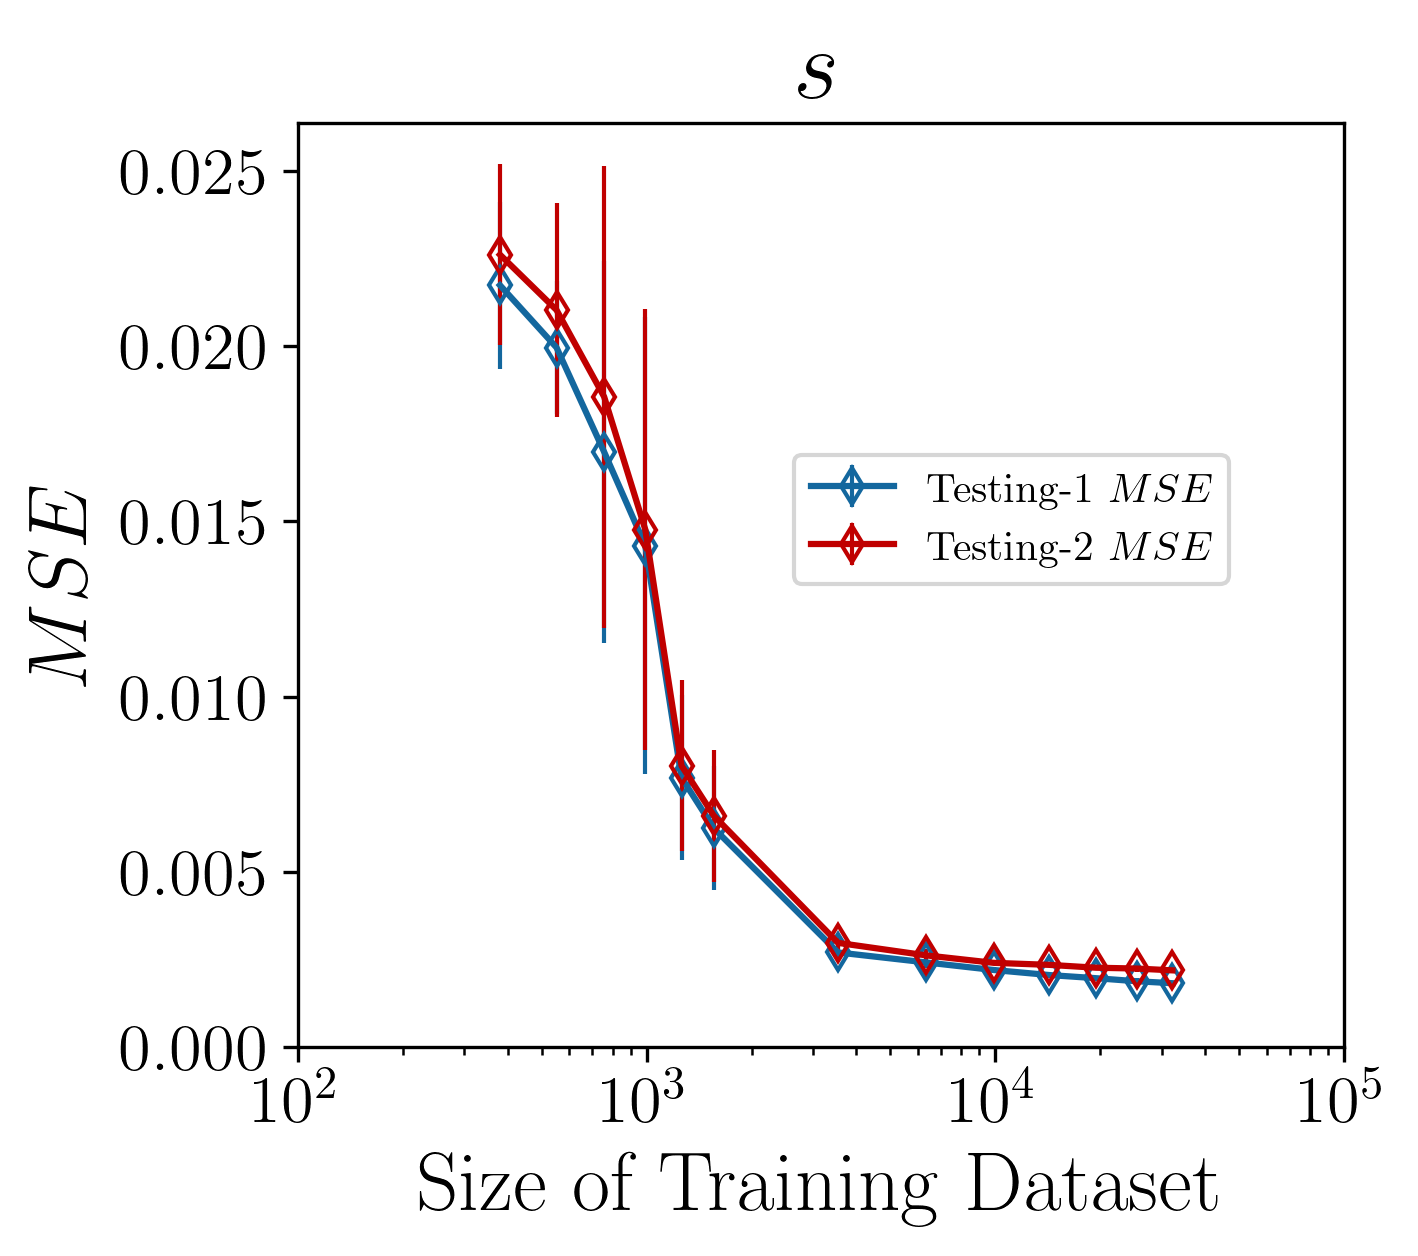

In [47]:
fig, ax1 = plt.subplots(figsize=(4.5, 4), dpi=300)
ax1.errorbar(
    testing1_size_performance["size"]
    * 200
    * (testing1_size_performance["size"] * 200 - 1),
    testing1_size_performance["s_MSE_sym_mean"],
    testing1_size_performance["s_MSE_sym_std"],
    marker="d",
    color="#13679E",
    ecolor="#13679E",
    elinewidth=1,
    label=r"Testing-1 $MSE$",
    markerfacecolor="none",  # Make the inside of the marker blank
    markeredgecolor="#13679E",
)

ax1.errorbar(
    testing2_size_performance["size"]
    * 200
    * (testing2_size_performance["size"] * 200 - 1),
    testing2_size_performance["s_MSE_sym_mean"],
    testing2_size_performance["s_MSE_sym_std"],
    marker="d",
    color="#C00000",
    ecolor="#C00000",
    elinewidth=1,
    label=r"Testing-2 $MSE$",
    markerfacecolor="none",  # Make the inside of the marker blank
    markeredgecolor="#C00000",
)

ax1.set_xscale("log")
ax1.set_xlim(100, 100000)
ax1.set_xlabel("Size of Training Dataset", size=20)
ax1.set_ylabel(r"$MSE$", size=20, color="k")
ax1.tick_params(axis="x", labelsize=16, colors="k")
ax1.tick_params(axis="y", labelsize=16, colors="k")
ax1.set_ylim(
    0,
)

# Adding a legendloc="right", bbox_to_anchor=(1, 1),
fig.legend(loc="center right", bbox_to_anchor=(0.83, 0.55))
plt.title("$s$", size=24, color="k")

# plt.tight_layout()
plt.savefig("performance_vs_size_MSE_for_s.svg", bbox_inches="tight", format="svg")
plt.show()

## $R^2$ and MAE for NGED

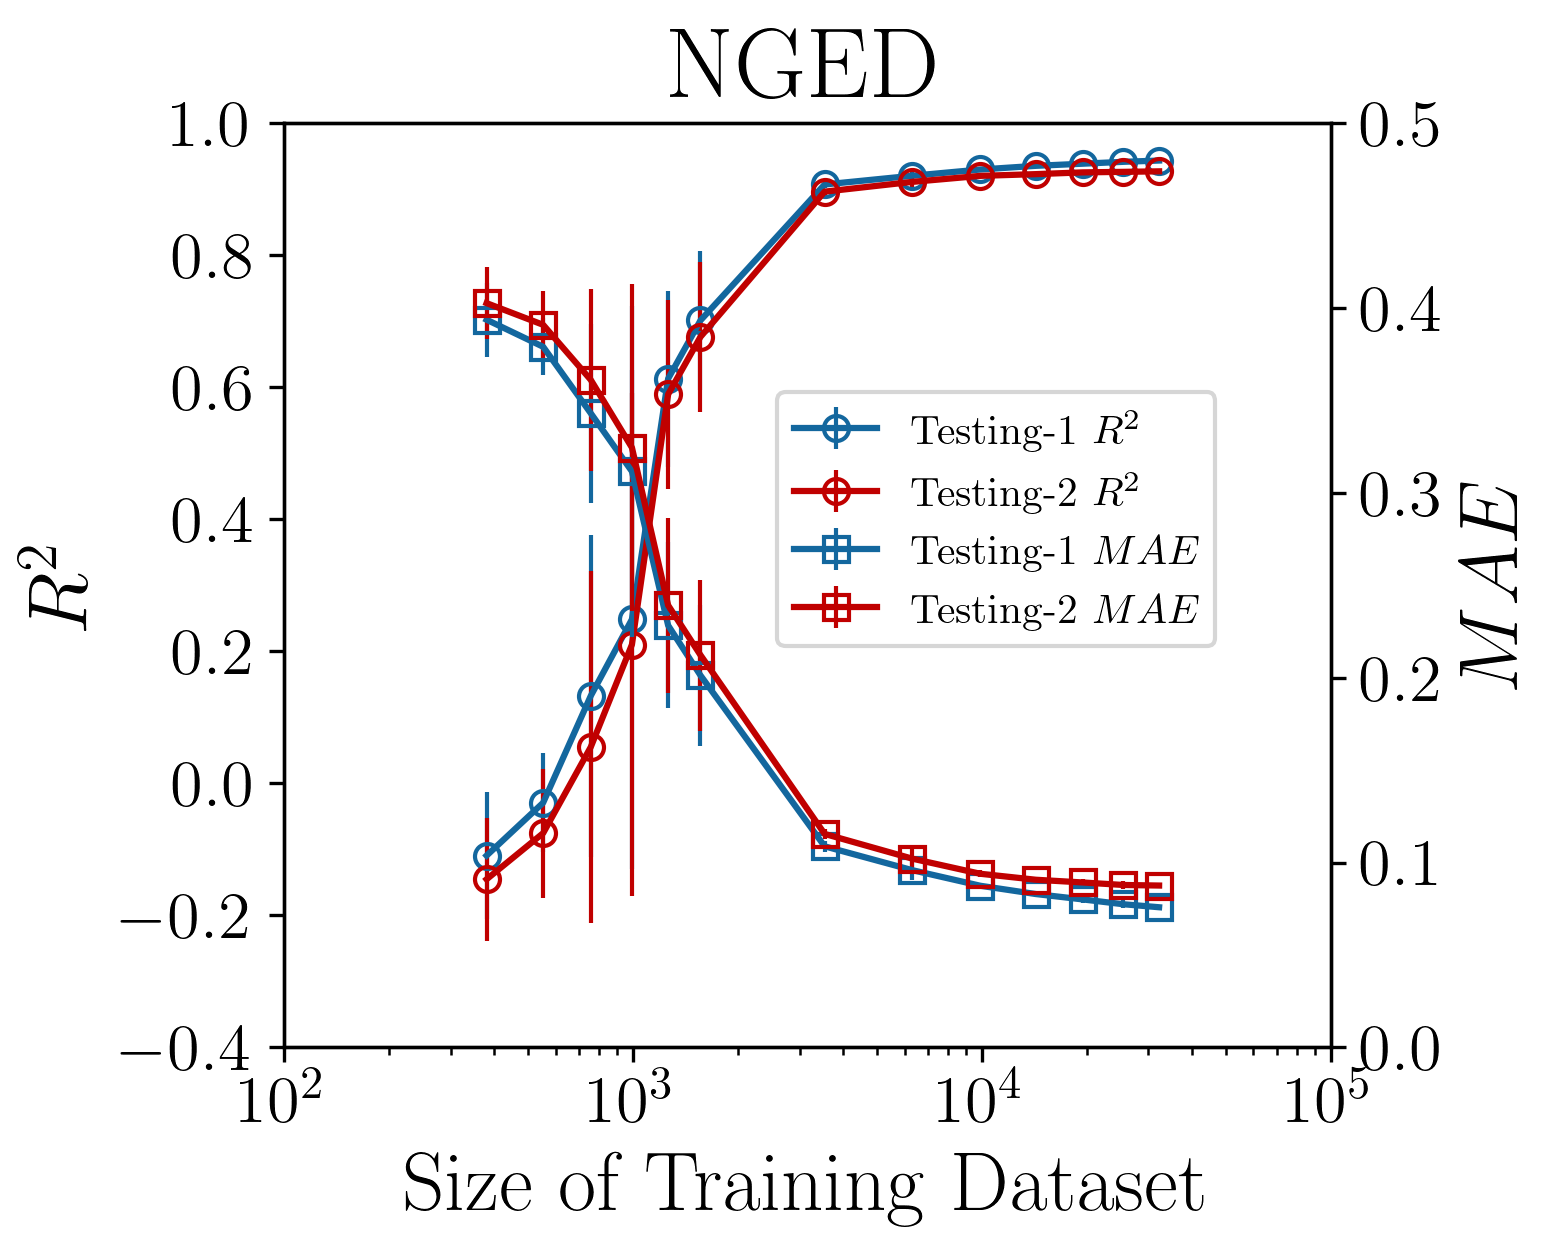

In [45]:
fig, ax1 = plt.subplots(figsize=(4.5, 4), dpi=300)
ax1.errorbar(
    testing1_size_performance["size"]
    * 200
    * (testing1_size_performance["size"] * 200 - 1),
    testing1_size_performance["NGED_R2_score_sym_mean"],
    testing1_size_performance["NGED_R2_score_sym_std"],
    marker="o",
    color="#13679E",
    ecolor="#13679E",
    elinewidth=1,
    label=r"Testing-1 $R^2$",
    markerfacecolor="none",  # Make the inside of the marker blank
    markeredgecolor="#13679E",
)

ax1.errorbar(
    testing2_size_performance["size"]
    * 200
    * (testing2_size_performance["size"] * 200 - 1),
    testing2_size_performance["NGED_R2_score_sym_mean"],
    testing2_size_performance["NGED_R2_score_sym_std"],
    marker="o",
    color="#C00000",
    ecolor="#C00000",
    elinewidth=1,
    label=r"Testing-2 $R^2$",
    markerfacecolor="none",  # Make the inside of the marker blank
    markeredgecolor="#C00000",
)

ax1.set_xscale("log")
ax1.set_xlim(100, 100000)
ax1.set_xlabel("Size of Training Dataset", size=20)
ax1.set_ylabel(r"$R^2$", size=20, color="k")
ax1.tick_params(axis="x", labelsize=16, colors="k")
ax1.tick_params(axis="y", labelsize=16, colors="k")
ax1.set_ylim(-0.4, 1)
ax1.set_yticks([-0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1])

# Second Y-axis:
ax2 = ax1.twinx()
ax2.errorbar(
    testing1_size_performance["size"]
    * 200
    * (testing1_size_performance["size"] * 200 - 1),
    testing1_size_performance["NGED_MAE_sym_mean"],
    testing1_size_performance["NGED_MAE_sym_std"],
    marker="s",
    color="#13679E",
    ecolor="#13679E",
    elinewidth=1,
    label=r"Testing-1 $MAE$",
    markerfacecolor="none",  # Make the inside of the marker blank
    markeredgecolor="#13679E",
)

ax2.errorbar(
    testing2_size_performance["size"]
    * 200
    * (testing2_size_performance["size"] * 200 - 1),
    testing2_size_performance["NGED_MAE_sym_mean"],
    testing2_size_performance["NGED_MAE_sym_std"],
    marker="s",
    color="#C00000",
    ecolor="#C00000",
    elinewidth=1,
    label=r"Testing-2 $MAE$",
    markerfacecolor="none",  # Make the inside of the marker blank
    markeredgecolor="#C00000",
)

ax2.set_ylabel(r"$MAE$", size=20, color="k")
ax2.tick_params(axis="y", labelsize=16, colors="k")
ax2.set_ylim(0.0, 0.5)

# Adding a legendloc="right", bbox_to_anchor=(1, 1),
fig.legend(loc="center right", bbox_to_anchor=(0.83, 0.55))
plt.title("NGED", size=24, color="k")

# plt.tight_layout()
plt.savefig(
    "performance_vs_size_r2_MAE_for_NGED.svg", bbox_inches="tight", format="svg"
)
plt.show()

## MSE for NGED

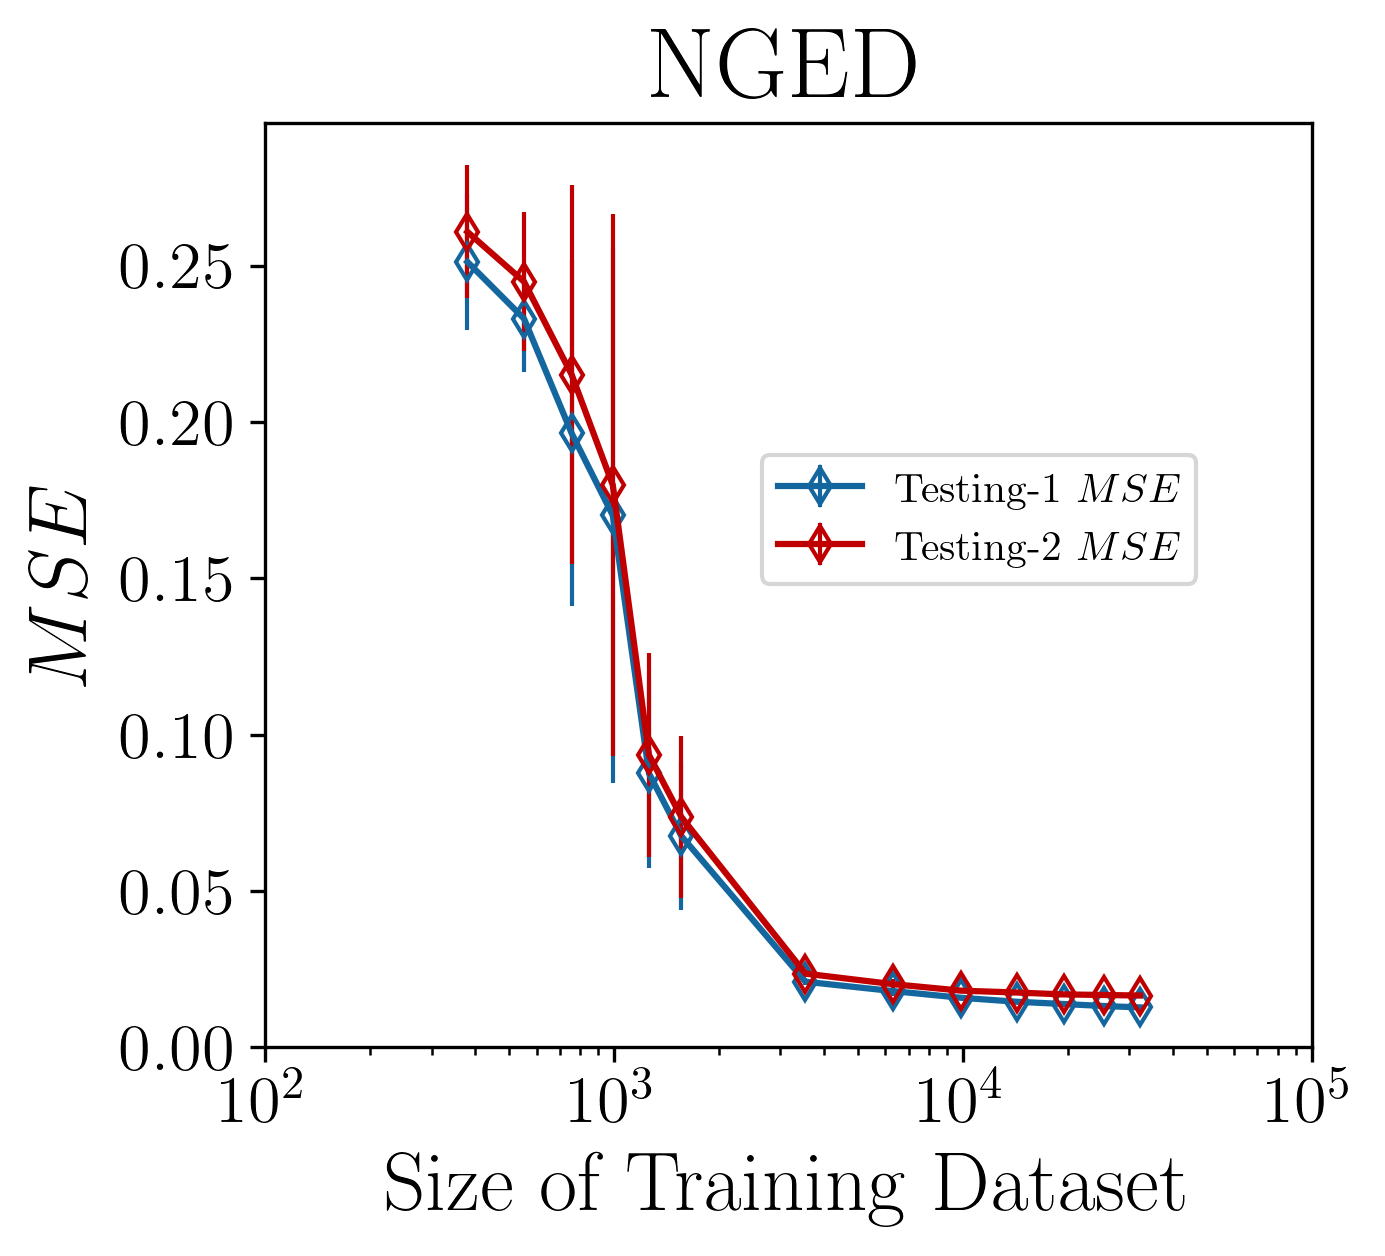

In [49]:
fig, ax1 = plt.subplots(figsize=(4.5, 4), dpi=300)
ax1.errorbar(
    testing1_size_performance["size"]
    * 200
    * (testing1_size_performance["size"] * 200 - 1),
    testing1_size_performance["NGED_MSE_sym_mean"],
    testing1_size_performance["NGED_MSE_sym_std"],
    marker="d",
    color="#13679E",
    ecolor="#13679E",
    elinewidth=1,
    label=r"Testing-1 $MSE$",
    markerfacecolor="none",  # Make the inside of the marker blank
    markeredgecolor="#13679E",
)

ax1.errorbar(
    testing2_size_performance["size"]
    * 200
    * (testing2_size_performance["size"] * 200 - 1),
    testing2_size_performance["NGED_MSE_sym_mean"],
    testing2_size_performance["NGED_MSE_sym_std"],
    marker="d",
    color="#C00000",
    ecolor="#C00000",
    elinewidth=1,
    label=r"Testing-2 $MSE$",
    markerfacecolor="none",  # Make the inside of the marker blank
    markeredgecolor="#C00000",
)

ax1.set_xscale("log")
ax1.set_xlim(100, 100000)
ax1.set_xlabel("Size of Training Dataset", size=20)
ax1.set_ylabel(r"$MSE$", size=20, color="k")
ax1.tick_params(axis="x", labelsize=16, colors="k")
ax1.tick_params(axis="y", labelsize=16, colors="k")
ax1.set_ylim(
    0,
)

# Adding a legendloc="right", bbox_to_anchor=(1, 1),
fig.legend(loc="center right", bbox_to_anchor=(0.83, 0.55))
plt.title("NGED", size=24, color="k")

# plt.tight_layout()
plt.savefig("performance_vs_size_MSE_for_NGED.svg", bbox_inches="tight", format="svg")
plt.show()

## $R^2$ and MAE for GED

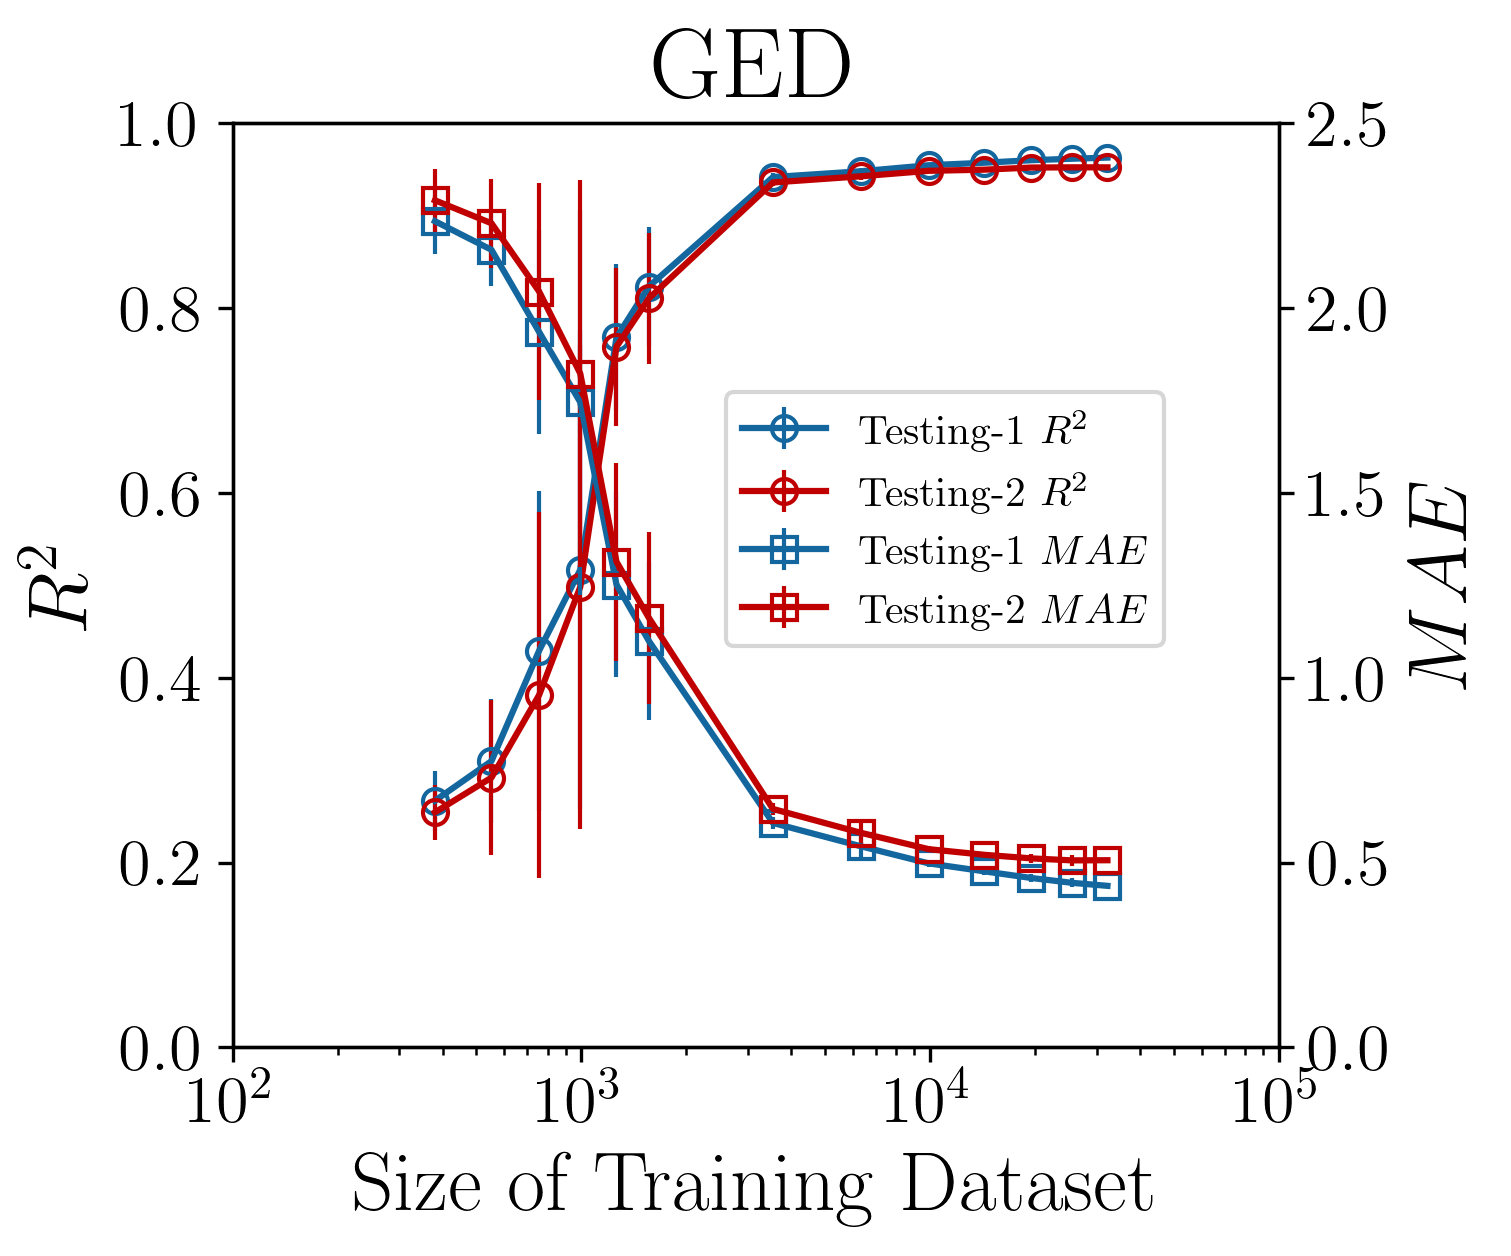

In [46]:
fig, ax1 = plt.subplots(figsize=(4.5, 4), dpi=300)
ax1.errorbar(
    testing1_size_performance["size"]
    * 200
    * (testing1_size_performance["size"] * 200 - 1),
    testing1_size_performance["GED_R2_score_sym_mean"],
    testing1_size_performance["GED_R2_score_sym_std"],
    marker="o",
    color="#13679E",
    ecolor="#13679E",
    elinewidth=1,
    label=r"Testing-1 $R^2$",
    markerfacecolor="none",  # Make the inside of the marker blank
    markeredgecolor="#13679E",
)

ax1.errorbar(
    testing2_size_performance["size"]
    * 200
    * (testing2_size_performance["size"] * 200 - 1),
    testing2_size_performance["GED_R2_score_sym_mean"],
    testing2_size_performance["GED_R2_score_sym_std"],
    marker="o",
    color="#C00000",
    ecolor="#C00000",
    elinewidth=1,
    label=r"Testing-2 $R^2$",
    markerfacecolor="none",  # Make the inside of the marker blank
    markeredgecolor="#C00000",
)

ax1.set_xscale("log")
ax1.set_xlim(100, 100000)
ax1.set_xlabel("Size of Training Dataset", size=20)
ax1.set_ylabel(r"$R^2$", size=20, color="k")
ax1.tick_params(axis="x", labelsize=16, colors="k")
ax1.tick_params(axis="y", labelsize=16, colors="k")
ax1.set_ylim(0, 1)

# Second Y-axis:
ax2 = ax1.twinx()
ax2.errorbar(
    testing1_size_performance["size"]
    * 200
    * (testing1_size_performance["size"] * 200 - 1),
    testing1_size_performance["GED_MAE_sym_mean"],
    testing1_size_performance["GED_MAE_sym_std"],
    marker="s",
    color="#13679E",
    ecolor="#13679E",
    elinewidth=1,
    label=r"Testing-1 $MAE$",
    markerfacecolor="none",  # Make the inside of the marker blank
    markeredgecolor="#13679E",
)

ax2.errorbar(
    testing2_size_performance["size"]
    * 200
    * (testing2_size_performance["size"] * 200 - 1),
    testing2_size_performance["GED_MAE_sym_mean"],
    testing2_size_performance["GED_MAE_sym_std"],
    marker="s",
    color="#C00000",
    ecolor="#C00000",
    elinewidth=1,
    label=r"Testing-2 $MAE$",
    markerfacecolor="none",  # Make the inside of the marker blank
    markeredgecolor="#C00000",
)

# ax2.set_yscale('log')
ax2.set_ylabel(r"$MAE$", size=20, color="k")
ax2.tick_params(axis="y", labelsize=16, colors="k")
ax2.set_ylim(0.0, 2.5)

# Adding a legendloc="right", bbox_to_anchor=(1, 1),
fig.legend(loc="center right", bbox_to_anchor=(0.83, 0.55))
plt.title("GED", size=24, color="k")

# plt.tight_layout()
plt.savefig("performance_vs_size_r2_MAE_for_GED.svg", bbox_inches="tight", format="svg")
plt.show()

## MAE for GED

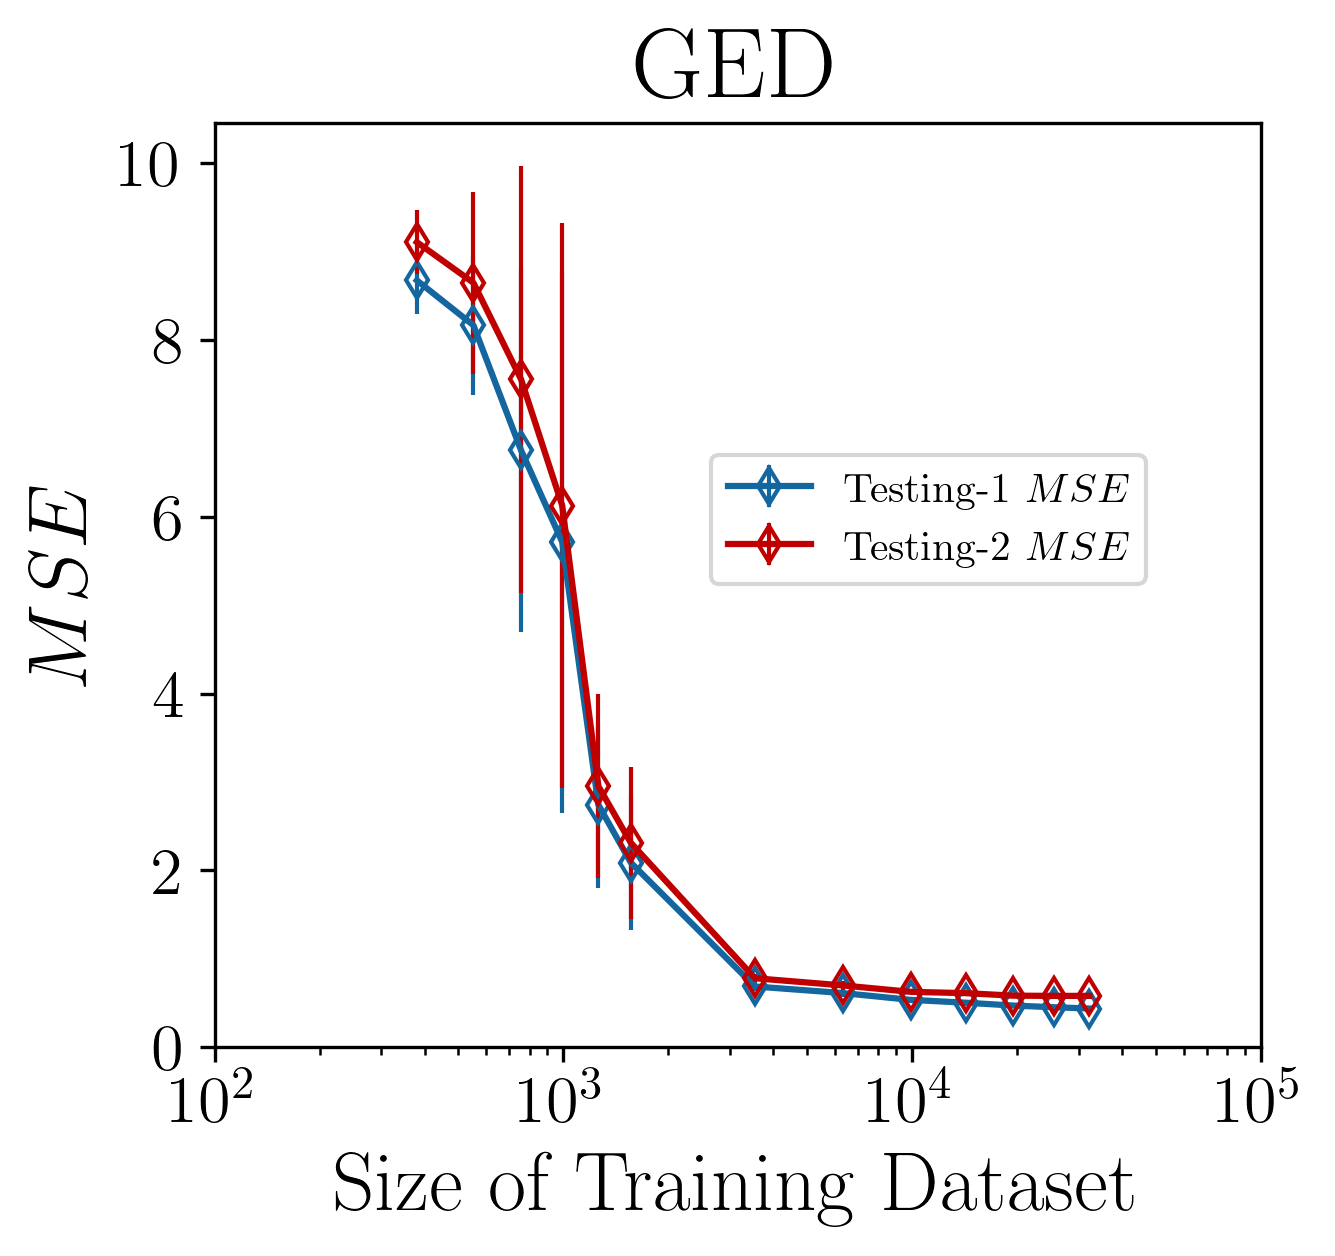

In [50]:
fig, ax1 = plt.subplots(figsize=(4.5, 4), dpi=300)
ax1.errorbar(
    testing1_size_performance["size"]
    * 200
    * (testing1_size_performance["size"] * 200 - 1),
    testing1_size_performance["GED_MSE_sym_mean"],
    testing1_size_performance["GED_MSE_sym_std"],
    marker="d",
    color="#13679E",
    ecolor="#13679E",
    elinewidth=1,
    label=r"Testing-1 $MSE$",
    markerfacecolor="none",  # Make the inside of the marker blank
    markeredgecolor="#13679E",
)

ax1.errorbar(
    testing2_size_performance["size"]
    * 200
    * (testing2_size_performance["size"] * 200 - 1),
    testing2_size_performance["GED_MSE_sym_mean"],
    testing2_size_performance["GED_MSE_sym_std"],
    marker="d",
    color="#C00000",
    ecolor="#C00000",
    elinewidth=1,
    label=r"Testing-2 $MSE$",
    markerfacecolor="none",  # Make the inside of the marker blank
    markeredgecolor="#C00000",
)

ax1.set_xscale("log")
ax1.set_xlim(100, 100000)
ax1.set_xlabel("Size of Training Dataset", size=20)
ax1.set_ylabel(r"$MSE$", size=20, color="k")
ax1.tick_params(axis="x", labelsize=16, colors="k")
ax1.tick_params(axis="y", labelsize=16, colors="k")
ax1.set_ylim(
    0,
)

# Adding a legendloc="right", bbox_to_anchor=(1, 1),
fig.legend(loc="center right", bbox_to_anchor=(0.83, 0.55))
plt.title("GED", size=24, color="k")

# plt.tight_layout()
plt.savefig("performance_vs_size_MSE_for_GED.svg", bbox_inches="tight", format="svg")
plt.show()